In [5]:
from causal_cocycle.loss_factory import CocycleLossFactory
from causal_cocycle.loss import FlowLoss
from causal_cocycle.optimise_new import optimise
from causal_cocycle.kernels import gaussian_kernel
from causal_cocycle.conditioners_new import CompositeConditioner, LinConditioner
from causal_cocycle.transformers_new import ShiftLayer, Transformer
from causal_cocycle.model_new import CocycleModel
from causal_cocycle.helper_functions import kolmogorov_distance
import torch

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
from scipy.stats import norm                  # for the true density
from ssvkernel import ssvkernel               # ← same function as before

# ---------- aesthetics (unchanged) ----------
plt.rcParams.update({
    'font.size': 20,
    'axes.titlesize': 24,
    'axes.labelsize': 20,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20
})
sns.set_style("whitegrid")
col_data, col_true = sns.color_palette("colorblind", 2)

# ---------- simulate data ----------
np.random.seed(42)
n = 1000
scale = 0.1
Z = np.random.normal(0, 1, n)*scale
B = np.random.choice([-1, 1], size=n)         # Rademacher(½)
X = Z + B                                     # mixture of N(±1, 1)
Y = np.random.normal(0,1,n) + X + Z

In [3]:
# Constructing Loss
torch.manual_seed(0)
kernel = [gaussian_kernel()] * 2
loss_factory = CocycleLossFactory(kernel)
V = torch.tensor((X,Z), dtype = torch.float32).T
Y = torch.tensor(Y).unsqueeze(-1)
loss= loss_factory.build_loss("CMMD_V", V, Y, subsamples=10**4)

# Constructing Model
conditioner = CompositeConditioner([LinConditioner(d = 2, p = 1, bias = False)])
transformer = ShiftLayer()
model = CocycleModel(conditioner = conditioner, transformer = Transformer([ShiftLayer()]))

# Optimizing 
losses = optimise(model, inputs = V,outputs = Y, loss_tr = loss, learn_rate = 1e-2, batch_size = 128)

/tmp/ipykernel_3039509/9969691.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1706712279749/work/torch/csrc/utils/tensor_new.cpp:261.)
  V = torch.tensor((X,Z), dtype = torch.float32).T


Epoch 1/100, Training Loss: -0.5405
Epoch 2/100, Training Loss: -0.5528
Epoch 3/100, Training Loss: -0.5637
Epoch 4/100, Training Loss: -0.5671
Epoch 5/100, Training Loss: -0.5742
Epoch 6/100, Training Loss: -0.5740
Epoch 7/100, Training Loss: -0.5834
Epoch 8/100, Training Loss: -0.5864
Epoch 9/100, Training Loss: -0.5806
Epoch 10/100, Training Loss: -0.5731
Epoch 11/100, Training Loss: -0.5871
Epoch 12/100, Training Loss: -0.5901
Epoch 13/100, Training Loss: -0.6040
Epoch 14/100, Training Loss: -0.5942
Epoch 15/100, Training Loss: -0.5840
Epoch 16/100, Training Loss: -0.5878
Epoch 17/100, Training Loss: -0.5856
Epoch 18/100, Training Loss: -0.6029
Epoch 19/100, Training Loss: -0.5811
Epoch 20/100, Training Loss: -0.6026
Epoch 21/100, Training Loss: -0.5941
Epoch 22/100, Training Loss: -0.6001
Epoch 23/100, Training Loss: -0.5758
Epoch 24/100, Training Loss: -0.5809
Epoch 25/100, Training Loss: -0.5963
Epoch 26/100, Training Loss: -0.5874
Epoch 27/100, Training Loss: -0.5927
Epoch 28/1

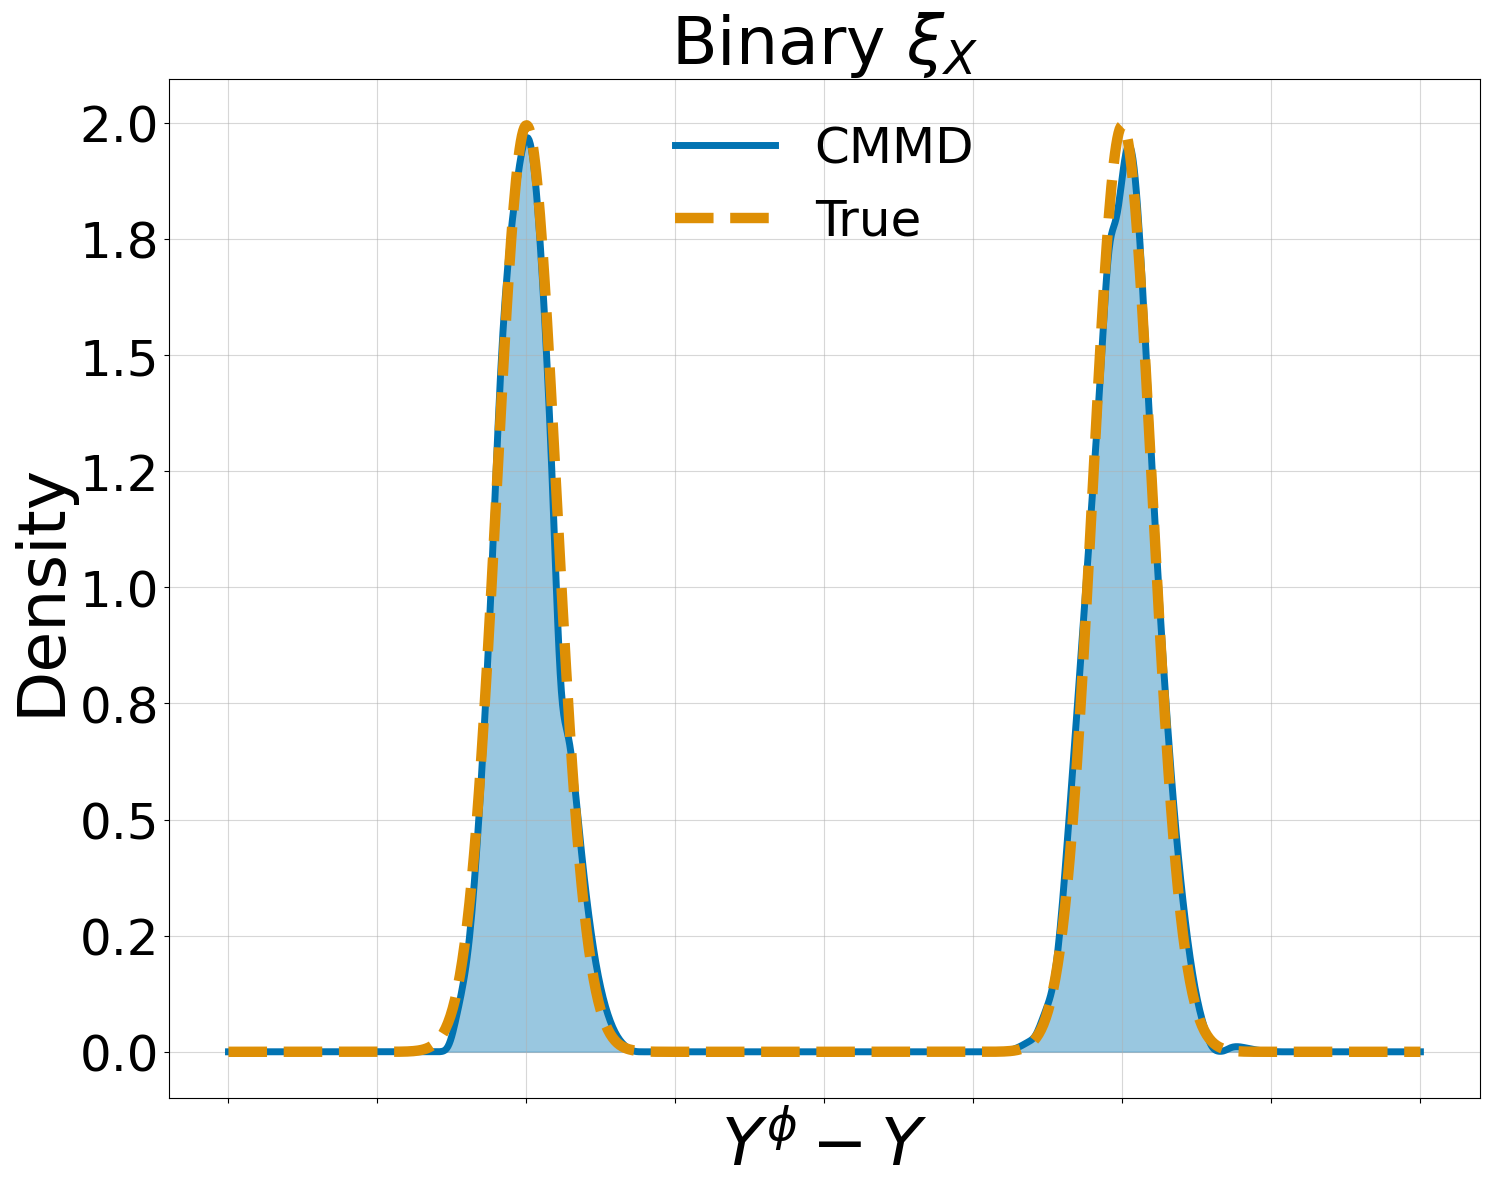

In [74]:
# ---------- density estimate with ssvkernel ----------
coef = conditioner.layers[0].state_dict()['linear.weight'][0][0]
x_grid = np.linspace(-2, 2, 1000)
# y_hat is returned as a tuple (density, bandwidth); we only need density
y_hat = ssvkernel(X*coef.numpy(), tin=x_grid, M=80, nbs=100, WinFunc='Gauss')[0]


# ---------- analytic reference density ----------
y_true = 0.5 * norm.pdf(x_grid, -1, scale) + 0.5 * norm.pdf(x_grid, 1, scale)

# ---------- plot ----------
plt.rcdefaults()
fig, ax = plt.subplots(figsize=(15, 12))
ax.plot(x_grid, y_hat, color=col_data, lw=5, label="CMMD")
ax.fill_between(x_grid, 0, y_hat, color=col_data, alpha=0.4)
ax.plot(x_grid, y_true, color=col_true, lw=7.5, ls="--", label="True")

ax.set_xlabel(r"$Y^\phi - Y$", fontsize = 48)
ax.set_ylabel("Density", fontsize = 48)
ax.set_xticklabels([],fontsize = 36)
ax.set_yticklabels([],fontsize = 36)
ax.set_title(r"Binary $\xi_X$", fontsize = 48)
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f'))
ax.legend(frameon=False, fontsize=36)
ax.grid(alpha = 0.5)

fig.tight_layout()
fig.savefig("treatment_effect_rad.png", bbox_inches="tight")
plt.show()

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
from scipy.stats import betaprime, norm
from ssvkernel import ssvkernel          # same density estimator as before

# ---------------- aesthetics (unchanged) ----------------
plt.rcParams.update({
    'font.size': 20,
    'axes.titlesize': 24,
    'axes.labelsize': 20,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20
})
sns.set_style("whitegrid")
col_est, col_true = sns.color_palette("colorblind", 2)

# ---------------- helper: draw |NBP(0.1,0.1)| ---------
def draw_abs_nbp(size):
    """
    |NBP(0.1,0.1)|  where  NB P  is  Normal–Beta-Prime:
      τ   ~ BetaPrime(0.1, 0.1)
      V|τ ~ N(0, τ)
      return |V|
    """
    τ   = betaprime.rvs(0.1, 0.1, size=size)
    v   = norm.rvs(scale=np.sqrt(τ))
    return np.abs(v)

# ---------------- simulate data -------------------------
np.random.seed(44)
n = 1000
scale = 0.1
Z        = np.random.normal(0, scale, n)

# mixture noise:   ½ |N(0,1)|   –   ½ |NBP(0.1,0.1)|
B        = np.random.binomial(1, 0.5, n)            # 1 ⇒ positive branch
T        = B *  np.abs(np.random.normal(size=n))    \
         - (1 - B) * draw_abs_nbp(n)

X_raw    = Z + T
X_        = 1 / (1 + np.exp(-X_raw))                 # logistic scaling ⇒ (0,1)
Y_ = np.random.normal(0,1,n) + X + Z

/tmp/ipykernel_2310844/2400030237.py:43: RuntimeWarning: overflow encountered in exp
  X_        = 1 / (1 + np.exp(-X_raw))                 # logistic scaling ⇒ (0,1)


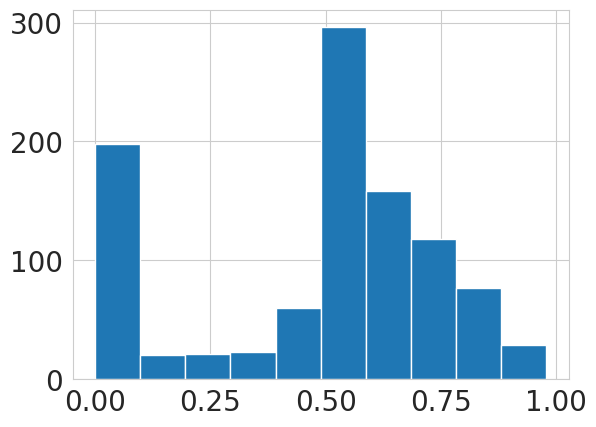

In [12]:
plt.hist(torch.sigmoid(torch.tensor(T)));

In [ ]:
# Constructing Loss
torch.manual_seed(0)
kernel = [gaussian_kernel()] * 2
loss_factory = CocycleLossFactory(kernel)
V = torch.tensor((X_,Z), dtype = torch.float32).T
Y_ = torch.tensor(Y_).unsqueeze(-1)
loss= loss_factory.build_loss("CMMD_V", V, Y_, subsamples=10**4)

# Constructing Model
conditioner = CompositeConditioner([LinConditioner(d = 2, p = 1, bias = False)])
transformer = ShiftLayer()
model = CocycleModel(conditioner = conditioner, transformer = Transformer([ShiftLayer()]))

# Optimizing 
losses = optimise(model, inputs = V,outputs = Y_, loss_tr = loss, learn_rate = 1e-2, batch_size = 128)

/tmp/ipykernel_3039509/3214340316.py:14: RuntimeWarning: overflow encountered in exp
  X_ref   = 1 / (1 + np.exp(-(Z_ref + T_ref)))


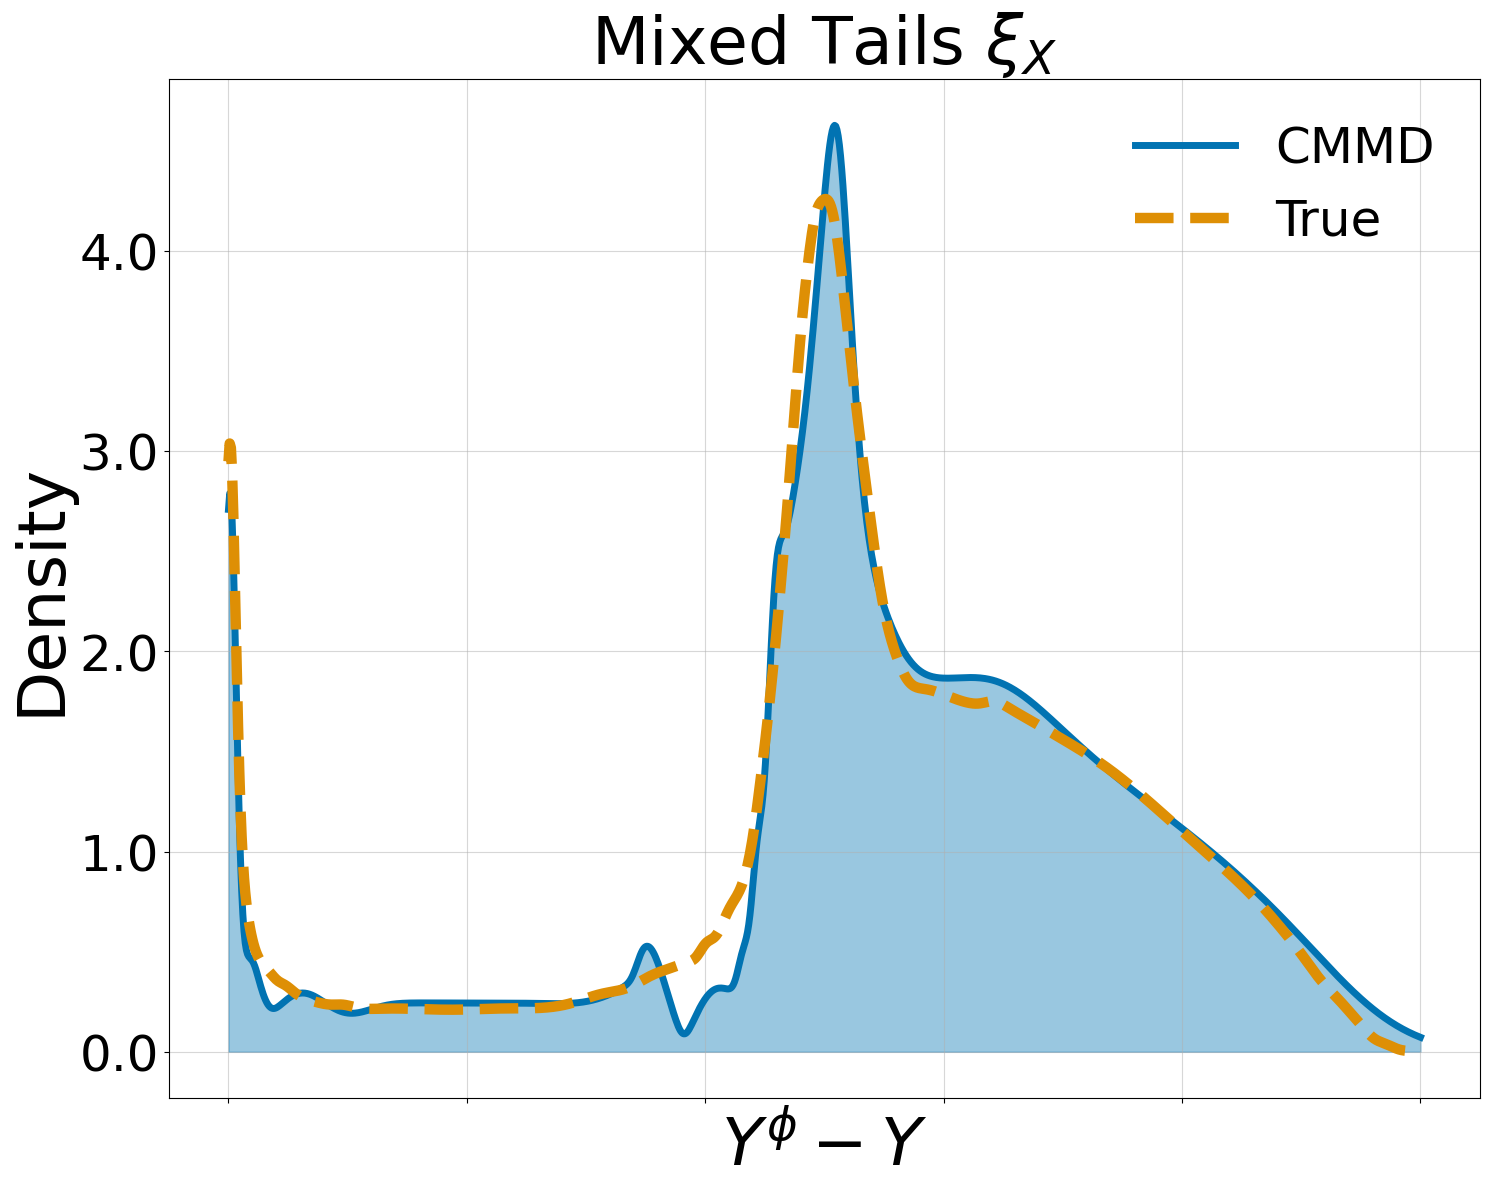

In [72]:
# ---------------- density estimate ----------------------
coef = conditioner.layers[0].state_dict()['linear.weight'][0][0]
x_grid = np.linspace(1e-6, 1-1e-6, 1000)            # avoid endpoints
y_hat  = ssvkernel(X_, tin=x_grid, M=80, nbs=100, WinFunc='Gauss')[0]
# y_hat is returned as a tuple (density, bandwidth); we only need density
y_hat = ssvkernel(X_*coef.numpy(), tin=x_grid, M=80, nbs=100, WinFunc='Gauss')[0]

# ---------------- high-resolution Monte-Carlo reference -
n_ref   = 100_000
Z_ref   = np.random.normal(0, scale, n_ref)
B_ref   = np.random.binomial(1, 0.5, n_ref)
T_ref   = B_ref * np.abs(np.random.normal(size=n_ref)) \
        - (1 - B_ref) * draw_abs_nbp(n_ref)
X_ref   = 1 / (1 + np.exp(-(Z_ref + T_ref)))
y_true  = ssvkernel(X_ref, tin=x_grid, M=80, nbs=100, WinFunc='Gauss')[0]

# ---------- plot ----------
plt.rcdefaults()
fig, ax = plt.subplots(figsize=(15, 12))
ax.plot(x_grid, y_hat, color=col_data, lw=5, label="CMMD")
ax.fill_between(x_grid, 0, y_hat, color=col_data, alpha=0.4)
ax.plot(x_grid, y_true, color=col_true, lw=7.5, ls="--", label="True")

ax.set_xlabel(r"$Y^\phi - Y$", fontsize = 48)
ax.set_ylabel("Density", fontsize = 48)
ax.set_xticklabels([],fontsize = 36)
ax.set_yticklabels([],fontsize = 36)
ax.set_title(r"Mixed Tails $\xi_X$", fontsize = 48)
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f'))
ax.legend(frameon=False, fontsize=36)
ax.grid(alpha = 0.5)

fig.tight_layout()
fig.savefig("treatment_effect_nbp.png", bbox_inches="tight")
plt.show()